# Huấn luyện mạng Neural Networks

- NN với non-linear activation sau khi huấn luyện sẽ xấp xỉ được hàm mapping từ input -> output ( từ ảnh -> chữ số trong ảnh)
- Huấn luyện: 
    - Input: real data (dạng Tensor)
    - Forward -> Prediction (dự đoán)
    - Loss function : Độ tốt/ kém của dự đoán đó (MSE, NLL, BCE...)
    - Backpropagtion (or chain-rule): Tính $\nabla W = \frac{\partial Loss}{\partial W}$
    - Cập nhật tham số $W \leftarrow \alpha * \nabla W$ 
>  You can think of this like descending a mountain by following the steepest slope to the base.

Chain-rule
`$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

Gradient desent step
$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

### Losses trong Pytorch

`nn.CrossEntropyLoss` = `nn.LogSoftmax()` & `nn.NLLLoss()`

Input của `nn.CrossEntropyLoss` là `logits` - kết quả của X.dot(W), chưa đi qua softmax

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [2]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3133, grad_fn=<NllLossBackward>)


Tác giả gợi ý nên dùng `nn.LogSoftmax()` hoặc `F.log_softmax` đi cùng với `nn.NLLLoss()`

> **Exercise**: Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for nn.LogSoftmax and F.log_softmax you'll need to set the dim keyword argument appropriately. dim=0 calculates softmax across the rows, so each column sums to 1, while dim=1 calculates across the columns so each row sums to 1. Think about what you want the output to be and choose dim appropriately.

In [3]:
# TODO: Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3012, grad_fn=<NllLossBackward>)


### Autograd

- Autograd: Tự động tính gradients cho tensors
- Cách hoạt động: Theo dõi từng phép toán của tensors, backwards ngược lại qua các phép toán đó và tính gradient (eg: Define hàm `__add__` với parents node)
- Sử dụng Pytorch autograd để tính $\frac{\partial Loss}{\partial W}$ 
- `x.requires_grad_(True)` hoặc set `requires_grad = True` cho 1 tensor để đảm bảo Autograd "keep track" tensor đó. 
- Turn off gradient cho 1 block sử dụng `torch.no_grad()` (Thường sử dụng trong lúc test),
- Cho tất cả: `torch.set_grad_enabled(True|False)`

In [4]:
x = torch.zeros(1, requires_grad=True)
with torch.no_grad():
    y = x * 2
print(y.requires_grad)

False


In [5]:
x = torch.randn(2,2, requires_grad=True)
y = x**2
print(x, "\n", y)

tensor([[-0.0973, -0.0286],
        [-0.0226, -1.3194]], requires_grad=True) 
 tensor([[9.4695e-03, 8.1808e-04],
        [5.0977e-04, 1.7407e+00]], grad_fn=<PowBackward0>)


In [6]:
z = y.mean()
print(z)

tensor(0.4379, grad_fn=<MeanBackward0>)


In [7]:
print(x.grad)
print(y.grad)

None
None


In [8]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.0487, -0.0143],
        [-0.0113, -0.6597]])
tensor([[-0.0487, -0.0143],
        [-0.0113, -0.6597]], grad_fn=<DivBackward0>)


Để tính gradients, gọi method `backward`. Khi z gọi `backward`, `x.grad` sẽ là $\frac{\partial z}{\partial x}$
$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

### Loss and Autograd together

- Trong pytorch, mọi parameters được khởi tạo với requires_grad=True
- Khi `loss.backward()`, gradients cho từng parameter được tính, và sử dụng cho update weights với gradient descent

In [9]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [10]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0020,  0.0020,  0.0020,  ...,  0.0020,  0.0020,  0.0020],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [ 0.0020,  0.0020,  0.0020,  ...,  0.0020,  0.0020,  0.0020],
        ...,
        [-0.0014, -0.0014, -0.0014,  ..., -0.0014, -0.0014, -0.0014],
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010],
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009]])


### Training the network!

Sử dụng các optimizers trong `optim`, vd `otpim.SGD`

In [11]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

- Khi gọi `loss.backward()` qua nhiều lần với cùng 1 bộ parameters, gradients bị cộng dồn
- Sử dụng `optimizer.zero_grad()` để đưa gradient về 0 sau mỗi training pass

In [12]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -\n', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0149, -0.0294, -0.0160,  ..., -0.0341,  0.0111,  0.0048],
        [-0.0087,  0.0227, -0.0271,  ..., -0.0281, -0.0315,  0.0293],
        [-0.0005,  0.0068,  0.0036,  ..., -0.0192, -0.0062, -0.0317],
        ...,
        [-0.0343,  0.0108, -0.0170,  ..., -0.0064, -0.0196, -0.0098],
        [-0.0223, -0.0111, -0.0253,  ..., -0.0086,  0.0131,  0.0311],
        [-0.0285,  0.0054,  0.0023,  ...,  0.0112,  0.0087, -0.0250]],
       requires_grad=True)
Gradient -
 tensor([[ 2.6238e-03,  2.6238e-03,  2.6238e-03,  ...,  2.6238e-03,
          2.6238e-03,  2.6238e-03],
        [-7.4986e-05, -7.4986e-05, -7.4986e-05,  ..., -7.4986e-05,
         -7.4986e-05, -7.4986e-05],
        [-1.3641e-04, -1.3641e-04, -1.3641e-04,  ..., -1.3641e-04,
         -1.3641e-04, -1.3641e-04],
        ...,
        [ 1.3588e-03,  1.3588e-03,  1.3588e-03,  ...,  1.3588e-03,
          1.3588e-03,  1.3588e-03],
        [ 7.0200e-04,  7.0200e-04,  7.0200e-04,  ...,  7.0200

In [13]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0148, -0.0294, -0.0160,  ..., -0.0342,  0.0110,  0.0048],
        [-0.0087,  0.0227, -0.0271,  ..., -0.0281, -0.0315,  0.0293],
        [-0.0005,  0.0068,  0.0036,  ..., -0.0192, -0.0062, -0.0317],
        ...,
        [-0.0343,  0.0108, -0.0170,  ..., -0.0065, -0.0196, -0.0098],
        [-0.0223, -0.0111, -0.0253,  ..., -0.0086,  0.0131,  0.0311],
        [-0.0285,  0.0054,  0.0023,  ...,  0.0112,  0.0087, -0.0250]],
       requires_grad=True)


### Training for real

> Exercise: Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [14]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        # TODO: Training pass
        output = model(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9188730010091624
Training loss: 0.854012284070444
Training loss: 0.5255496400569294
Training loss: 0.43114745340494715
Training loss: 0.3857703159517571


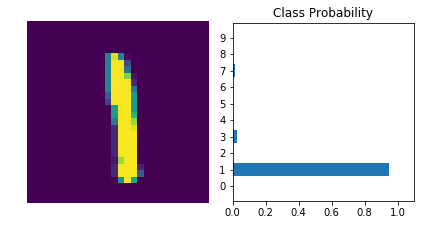

In [15]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)